In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing dataset
df = pd.read_csv('/content/Concrete_Data_Yeh.csv')
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
df.shape

(1030, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


The dataset is clean, fully numeric, and domain-driven, making it ideal for regression modeling. However, the small sample size and expected non-linear interactions require careful validation and conservative model complexity.

In [5]:
df.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


The dataset shows high variability and strong skewness across key material components and curing age, indicating non-linear relationships and interaction effects that favor tree-based regression models over linear approaches.

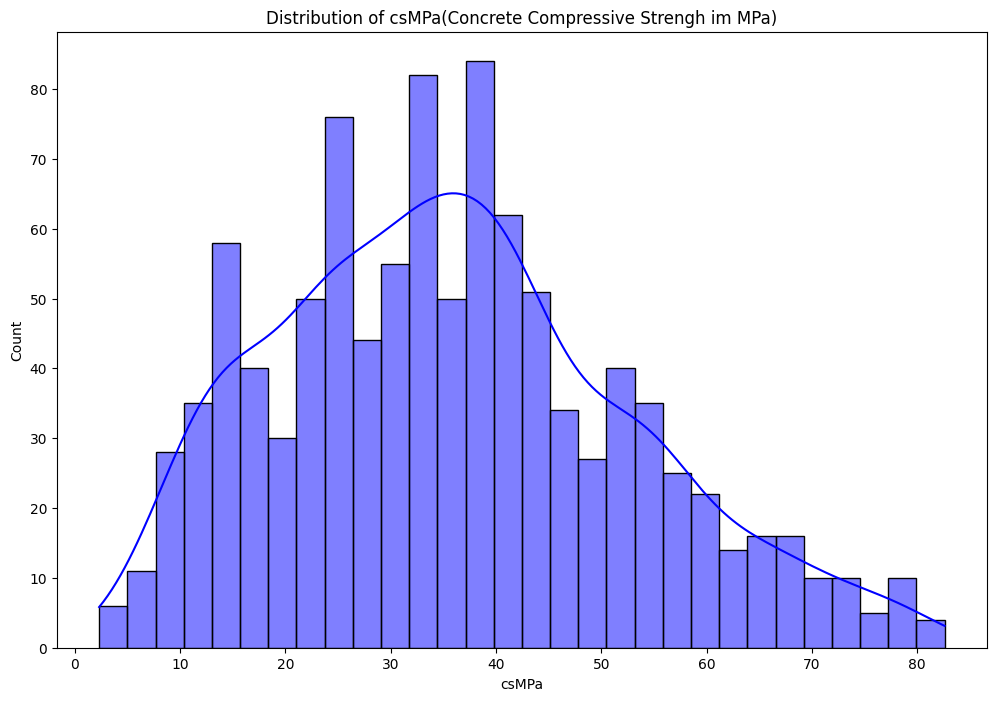

In [6]:
# Target distribution
plt.figure(figsize=(12,8))
sns.histplot(df['csMPa'], kde=True, color='blue', bins=30)
plt.title('Distribution of csMPa(Concrete Compressive Strengh im MPa)')
plt.xlabel('csMPa')
plt.show()

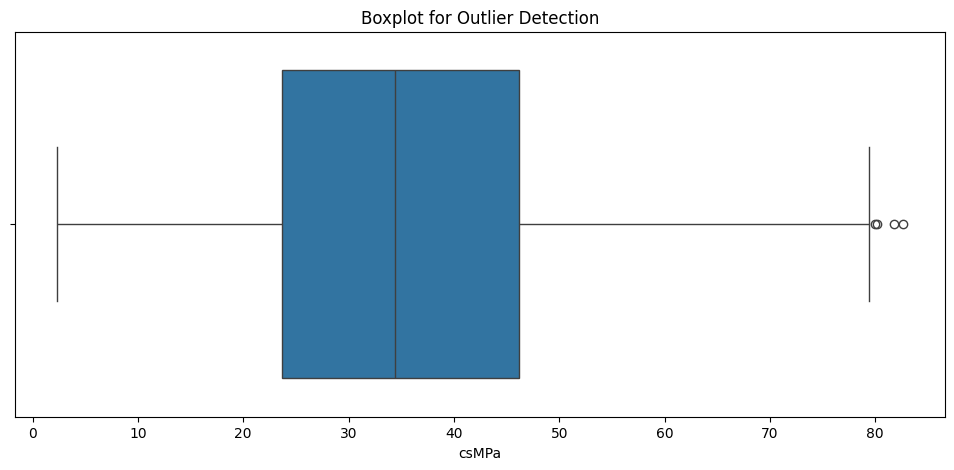

In [7]:
# Outliers
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='csMPa')
plt.title('Boxplot for Outlier Detection')
plt.show()

The target variable exhibits a right-skewed distribution with a small number of high-strength outliers that are physically meaningful. These observations are retained, as they reflect real high-performance concrete mixes and are essential for realistic model behavior

In [8]:
len(df.columns)

9

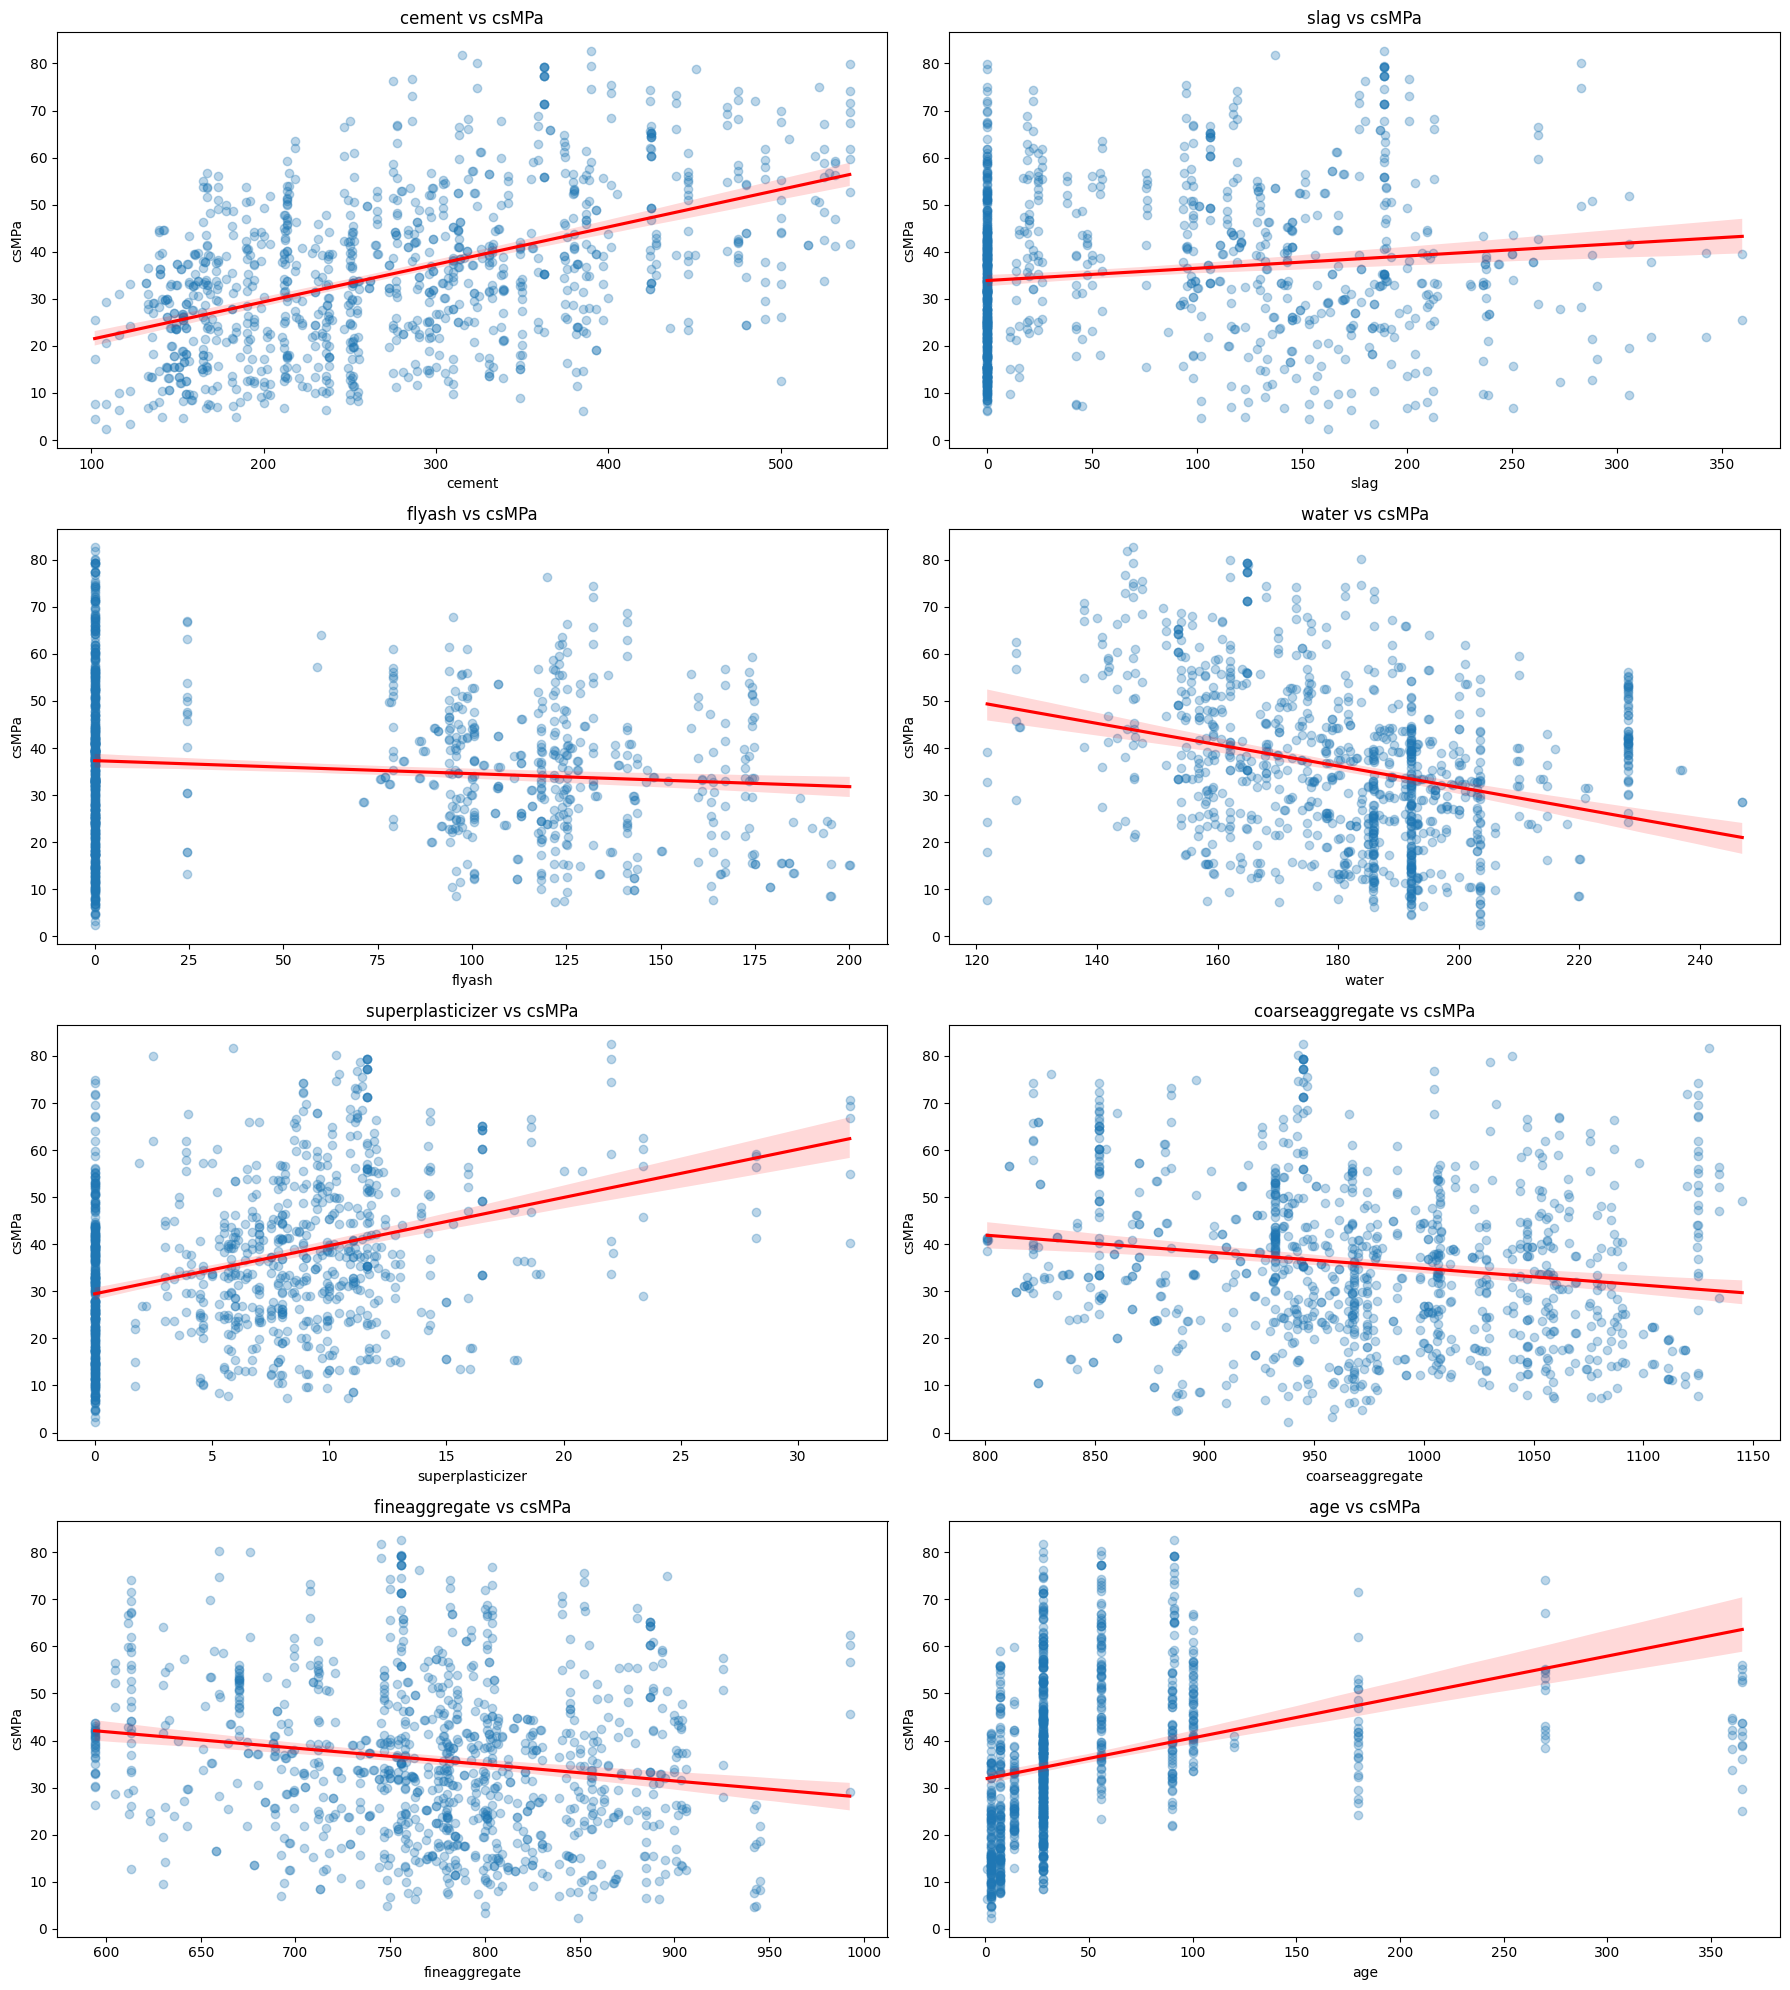

In [9]:
# Scatter Plots with regression lines
feature_cols = df.columns.drop('csMPa')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,20))
axes = axes.flatten()
for ax, col in zip(axes, feature_cols):
  sns.regplot(data=df, x=col, y='csMPa', ax=ax, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
  ax.set_title(f'{col} vs csMPa')

plt.tight_layout()
plt.show()

Scatter plots highlight interaction-driven effects, particularly between water, cement, and superplasticizer, reinforcing the suitability of tree-based regression models for this dataset

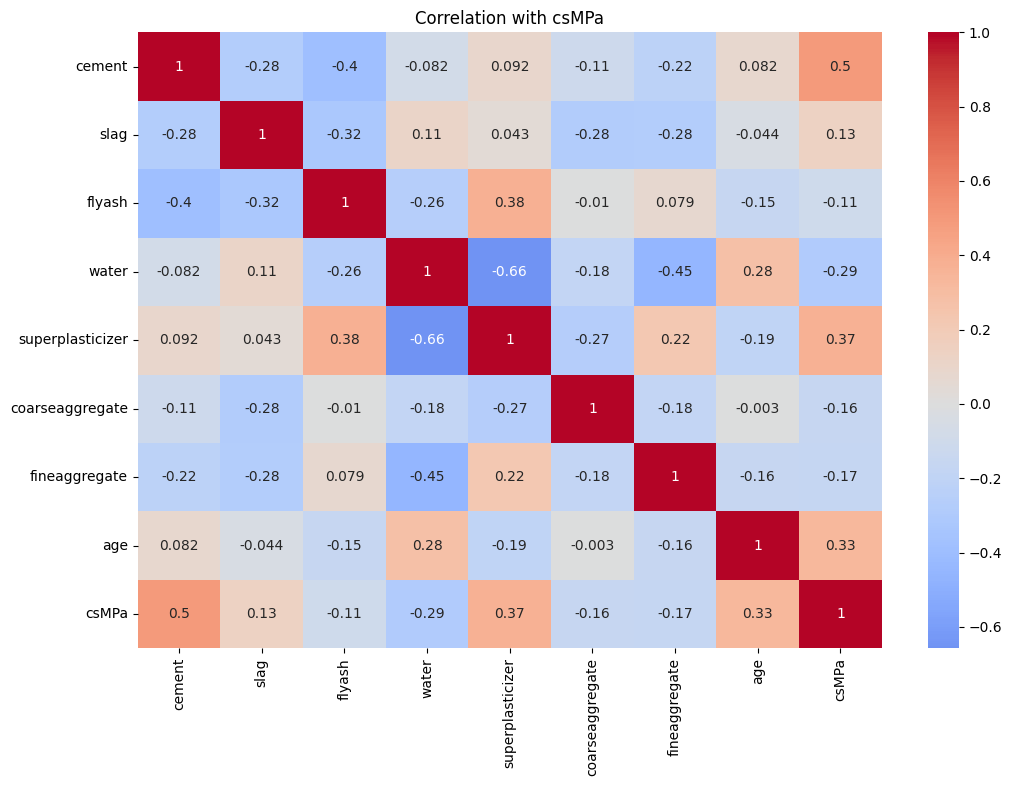

In [10]:
# # Calculating correlation
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with csMPa')
plt.show()

Correlation analysis reveals cement as the strongest linear predictor of compressive strength, while age and superplasticizer exhibit moderate correlations that understate their true non-linear influence

# **Model Building**

In [11]:
# sikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [12]:
# Spliting DataFrame into X and y (Features and Target)
X = df.drop(columns='csMPa')
y = df['csMPa']

# Train/Test split (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape

((824, 8), (206, 8))

In [14]:
# Creating a baseline Linear Regression model to compare with out Random Forest model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print('Linear Regression Test R2:', lr.score(X_test, y_test))
print('Linear Regression R2:', r2_score(y_test, y_pred_lr))
print('Linear Regression RMSE', rmse_lr)
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

Linear Regression Test R2: 0.627553179231485
Linear Regression R2: 0.627553179231485
Linear Regression RMSE 9.796475901624358
Linear Regression MAE: 7.745559243921434


In [15]:
# Random Forest Regression model
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('OOB R2:', rf.oob_score_)
print('Random Forest Test R2:', rf.score(X_test, y_test))

OOB R2: 0.9165366789063125
Random Forest Test R2: 0.882997006966324


In [16]:
min_leaf_values = [1, 3, 5, 10, 20]

for leaf in min_leaf_values:
    rf.set_params(min_samples_leaf=leaf)
    rf.fit(X_train, y_train)
    print(f'leaf:{leaf}, OOB R2: {rf.oob_score_}, r2_score:{r2_score(y_test, rf.predict(X_test))}')

leaf:1, OOB R2: 0.9165366789063125, r2_score:0.882997006966324
leaf:3, OOB R2: 0.9023874082295817, r2_score:0.8680847041066069
leaf:5, OOB R2: 0.8868071637752885, r2_score:0.855068662323721
leaf:10, OOB R2: 0.8532620848776744, r2_score:0.8203061601295569
leaf:20, OOB R2: 0.8001082554321509, r2_score:0.756722705398591


Based on the experiment and results, `min_samples_leaf=1` is the best choice in terms of predictive performance, while `min_samples_leaf=3` offers a more conservative bias–variance trade-off with minimal loss in accuracy.

In [17]:
# Final Random forest model
rf_final = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, random_state=42, n_jobs=-1, oob_score=True)

rf_final.fit(X_train, y_train)
y_pred_rf_final = rf_final.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_final))

print("Final OOB R²:", rf_final.oob_score_)
print("Final Test R²:", rf_final.score(X_test, y_test))
print('Random Forest RMSE:', rmse_rf)
print('Random Forest MAE:', mean_absolute_error(y_test, y_pred_rf_final))

Final OOB R²: 0.9023874082295817
Final Test R²: 0.8680847041066069
Random Forest RMSE: 5.83022501836955
Random Forest MAE: 4.256993399793737


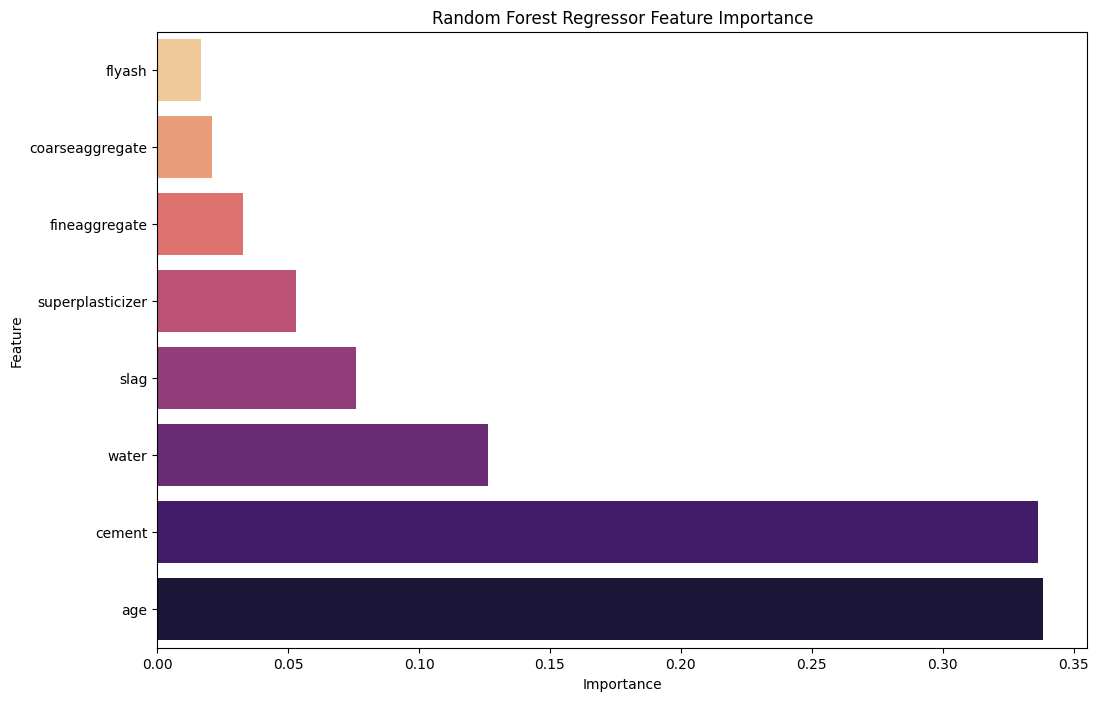

In [18]:
# Feature names and Importance
importances = rf_final.feature_importances_
feature_name = X_train.columns

# Converting to DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_name,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=fi_df, x='Importance', y='Feature', hue='Feature', palette='magma')
plt.gca().invert_yaxis()
plt.title('Random Forest Regressor Feature Importance')
plt.xlabel('Importance')
plt.show()

Feature importance analysis from the Random Forest model indicates that curing age and cement content are the dominant predictors of compressive strength, followed by water content. Supplementary materials such as slag and superplasticizer exhibit moderate importance, reflecting their interaction-driven effects. Aggregates and fly ash contribute less to predictive performance. These results align closely with both exploratory analysis and domain knowledge, supporting the validity of the model.

# **Final Project Conclusion & Limitations**

---

## **Final Conclusion**

This project aimed to predict **concrete compressive strength (`csMPa`)** using mix composition and curing age, leveraging both exploratory data analysis and machine learning models. The dataset was found to be **clean**, **fully numerical**, and **domain-driven**, with no missing values or categorical variables, allowing the analysis to focus on understanding underlying relationships rather than preprocessing challenges.

---

## **Modeling Approach and Performance**

A **Linear Regression** model was established as a baseline, achieving a **test R²** of approximately **0.63** with relatively high prediction error. While interpretable, this model failed to capture the complex non-linear behavior inherent in concrete strength development.

In contrast, a **Random Forest Regressor** with **Out-of-Bag (OOB) validation** significantly improved performance. The final model achieved a **Test R² of ~0.87**, reducing RMSE from nearly **10 MPa** to **~5.8 MPa** and MAE from **~7.7 MPa** to **~4.2 MPa**, demonstrating a substantial and meaningful improvement in predictive accuracy. The close alignment between OOB R² (~0.90) and test R² further indicates strong generalization and minimal overfitting.

## **Project Concution**

Overall, this project demonstrates that **tree-based models are well-suited for modeling concrete compressive strength**, where non-linearity, feature interactions, and physical constraints play a central role. The final Random Forest model provides a robust, interpretable, and practically useful solution without relying on aggressive hyperparameter tuning.

---

## **Final Takeaway**

This project successfully shows that **model choice must be driven by data characteristics**, not convenience. By grounding modeling decisions in EDA, prioritizing generalization over over-tuning, and validating results carefully, the final Random Forest model delivers **strong**, **realistic**, and **defensible predictions** of concrete compressive strength. The approach and conclusions are suitable for both practical applications and technical evaluation in interviews or academic settings.